# Load IMF's Global Debt Database

In [1]:
import requests
import pandas as pd
import pycountry
import re

#######################################
### ACCESS IMF GLOBAL DEBT DATABASE ###
#######################################

debtindicators = ['CG_DEBT_GDP']

all_data = []

for indicator in debtindicators:
    print(f'Downloading {indicator}...')
    url = f'https://www.imf.org/external/datamapper/api/v1/{indicator}'
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to fetch {indicator}: {response.status_code}")
        continue

    try:
        data = response.json()['values'][indicator]
    except KeyError:
        print(f"No data found for {indicator}")
        continue

    for ctry, year_dict in data.items():
        for year, value in year_dict.items():
            all_data.append({
                'ctry': ctry,
                'year': int(year),
                'indicator': indicator,
                'value': value
            })

# Convert list of records to DataFrame
df_raw = pd.DataFrame(all_data)

# Pivot to wide format
debtdata = df_raw.pivot(index=['ctry', 'year'], columns='indicator', values='value').reset_index()

# Add ctry_year column
debtdata['ctry_year'] = debtdata['ctry'] + '_' + debtdata['year'].astype(str)

# Reorder columns
cols = ['ctry_year', 'ctry', 'year'] + [col for col in debtdata.columns if col not in ['ctry_year', 'ctry', 'year']]
debtdata = debtdata[cols]

# Done
debtdata.set_index('ctry_year', inplace = True)
debtdata.drop(columns = ['ctry','year'],inplace=True)
debtdata


indicator,CG_DEBT_GDP
ctry_year,
AFG_2002,345.977479
AFG_2003,270.602364
AFG_2004,244.966691
AFG_2005,206.356007
AFG_2006,22.984644
...,...
ZWE_2019,82.337327
ZWE_2020,84.465998
ZWE_2021,58.171867


# Load World Bank Data

In [2]:
###########################
###ACCESS WORLD BANK API###
###########################

#function that retrieves values based on specified indicator and year#
def get_values(indicator_code, year):
    link = 'https://data360api.worldbank.org/data360/data?DATABASE_ID=WB_WDI&INDICATOR=' + indicator_code + '&TIME_PERIOD=' + year + '&skip=0'
    response = requests.get(link)
    if response.status_code != 200:
        print("Error:", response.status_code)
        return None

    df = {}

    for i in range(response.json()['count']):
        entry = response.json()['value'][i]
        value = entry['OBS_VALUE']
        ctry = entry['REF_AREA']
        year_val = entry['TIME_PERIOD']
        indicator = entry['INDICATOR']
        df[i] = [value, ctry, year_val, indicator]

    output = pd.DataFrame.from_dict(df, orient='index', columns=['value', 'ctry', 'year', 'indicator'])
    return output


#Select variables and date range#
#'WB_WDI_FB_AST_NPER_ZS', 'NPLratio'

#select indicators and map names
indicators = ['WB_WDI_NY_GDP_MKTP_KD_ZG', 'WB_WDI_NY_GDP_PCAP_CD', 'WB_WDI_FP_CPI_TOTL_ZG', 'WB_WDI_BN_CAB_XOKA_GD_ZS',
             'WB_WDI_FI_RES_TOTL_MO', 'WB_WDI_NY_GDP_MKTP_PP_CD','WB_WDI_GC_TAX_TOTL_GD_ZS','WB_WDI_GC_XPN_INTP_RV_ZS',
              'WB_WDI_PA_NUS_FCRF', 'WB_WDI_DT_DOD_DSTC_IR_ZS']
indicator_names = ['RGDPyy', 'GDPpc', 'CPI', 'CAgdp', 
                   'FXimp','GDPppp','Taxgdp','InterestRev', 
                   'FX','STDebt/Res']

year= range(2000,2020)
dataset = pd.DataFrame(columns=['value', 'ctry','year', 'indicator']) #empty dataframe

#Compile the data#
for i in indicators:
    for t in year:
        newdata = get_values(i, str(t))
        dataset = pd.concat([newdata, dataset])

In [3]:
################################
###WORLD BANK DATA PROCESSING###
################################

#Pivot data and drop NAs#
dataset['ctry_year'] = dataset['ctry']+'_'+dataset['year']
wbdata = dataset.pivot(index='ctry_year', columns='indicator', values='value')

#Force values to numeric and rename variables# 
for col in wbdata.columns:
    wbdata[col] = pd.to_numeric(wbdata[col], errors='coerce')

rename_dict = dict(zip(indicators, indicator_names)) #create mapping
wbdata = wbdata.rename(columns=rename_dict) # Apply renaming

# Compute YoY % change in exchange rate by country
wbdata['country'] = wbdata.index.str[:3]
wbdata['year'] = wbdata.index.str[-4:].astype(int)
wbdata.sort_values(by=['country', 'year'], inplace=True)
wbdata['FXchg'] = wbdata.groupby('country')['FX'].pct_change()

/var/folders/2m/2j3932455xb9cpxwmkx3jy8r0000gn/T/ipykernel_44109/941595742.py:20: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  wbdata['FXchg'] = wbdata.groupby('country')['FX'].pct_change()


# Load Sovereign Default Data

In [4]:
#####################################
### PROCESS SOVEREIGN DEFAULT DATA###
#####################################
defaults = pd.read_excel('/Users/darrenaw/Downloads/BoC-BoE-Database-2024.xlsx', sheet_name = 'Data_2024.csv', skiprows = 64)
defaults = defaults[['k','DEBT_TOTAL_2023']]
defaults.columns = ['ctry_year', 'default_amount']
defaults.set_index('ctry_year', inplace = True)
defaults['default'] = defaults['default_amount'].fillna(0).ne(0).astype(int)

# Load Ratings Data

In [5]:
############################
### PROCESS RATINGS DATA ###
############################

# Read and clean raw data
ratings = pd.read_excel("/Users/darrenaw/Downloads/ratingshistory.xlsx", header=None).iloc[2:]

# Process rows into structured format
records = []
current_country = current_iso = None

for _, row in ratings.iterrows():
    if pd.notna(row[0]) and pd.notna(row[1]):  # Country row
        current_country, current_iso = row[0].strip(), row[1].strip()
        continue
    
    if (date := pd.to_datetime(row[0], errors='coerce')) is not None:  # Rating row
        records.append({
            "country": current_country,
            "iso": current_iso,
            "date": date,
            "fx_rating": row[2],
            "local_rating": row[3],
            "tc_rating": row[4] if len(row) > 4 else None
        })

# Create DataFrame and process columns
ratings_clean = (pd.DataFrame(records)
                 .assign(iso3=lambda x: x['iso'].apply(lambda c: pycountry.countries.get(alpha_2=c).alpha_3 if c else None),
                         year=lambda x: x['date'].dt.year,
                         ctry_year=lambda x: x['iso3'] + '_' + x['year'].astype(str),
                         fx_grade=lambda x: x['fx_rating'].str.extract(r'([A-Z+-]+)')[0],
                         lc_grade=lambda x: x['local_rating'].str.extract(r'([A-Z+-]+)')[0])
                 .sort_values('date')
                 .drop_duplicates('ctry_year', keep='last'))

# Create complete index and forward fill
full_idx = pd.MultiIndex.from_product([ratings_clean['iso3'].unique(), 
                                      range(ratings_clean['year'].min(), ratings_clean['year'].max()+1)],
                                     names=['iso3', 'year'])

ratings_clean = (ratings_clean.set_index(['iso3', 'year'])
                 .reindex(full_idx)
                 .sort_index()
                 .groupby(level=0).ffill()
                 .reset_index()
                 .assign(ctry_year=lambda x: x['iso3'] + '_' + x['year'].astype(str))
                 .set_index('ctry_year')
                 .dropna())

In [6]:
######################
### MERGE DATASETS ###
######################
merged = wbdata.join(debtdata, how = 'outer')
merged = merged.join(defaults, how = 'outer')
#merge1 = merge1.dropna()
merged[['default_amount','default']] = merged[['default_amount','default']].fillna(0)
final = merged.merge(ratings_clean[['fx_grade', 'lc_grade', 'tc_rating']], 
    left_index=True, right_index=True, how='inner'
    )

final.drop(columns=['country', 'year'], inplace=True)

In [7]:
##########################################
### DROP UNWANTED YEARS AND AGGREGATES ###
##########################################

# Full list of aggregates to drop
droplist = [
    'AFE', 'EAR', 'AFW', 'ARB', 'CSS', 'CEB', 'EAS', 'EAP', 'TEA', 'EMU',
    'ECS', 'ECA', 'TEC', 'EUU', 'FCS', 'HPC', 'HIC', 'IBD', 'IBT', 'IDB',
    'IDX', 'IDA', 'LTE', 'LCN', 'LAC', 'TLA', 'LDC', 'LMY', 'LIC', 'LMC',
    'MEA', 'MNA', 'TMN', 'MIC', 'NAC', 'OED', 'OSS', 'PSS', 'PST', 'PRE',
    'SST', 'SAS', 'TSA', 'SSF', 'SSA', 'TSS', 'UMC', 'WLD'
]

#Drop specific years too
years_to_drop = ['2022', '2023']

# Build mask: country code in droplist or year in years_to_drop
mask = (
    final.index.str[:3].isin(droplist) |
    final.index.str[-4:].isin(years_to_drop)
)

# Apply mask to drop those rows
final = final[~mask]



# Impute missing data

In [8]:
#Make a copy of the dataset and extract country and year
df = final.copy()
df = df.reset_index()
df['country'] = df['ctry_year'].str[:3]
df['year'] = df['ctry_year'].str[-4:]

#List of macroeconomic columns to impute
macro_cols = ['CAgdp', 'STDebt/Res', 'FXimp', 'CPI', 'Taxgdp', 'InterestRev',
              'RGDPyy', 'GDPppp', 'GDPpc', 'FX', 'FXchg', 'CG_DEBT_GDP']

#Impute using country mean, then year mean
for col in macro_cols:
    # Fill with country average first
    df[col] = df.groupby('country')[col].transform(lambda x: x.fillna(x.mean()))
    
    # Then fill remaining NaNs with year average
    df[col] = df.groupby('year')[col].transform(lambda x: x.fillna(x.mean()))

#Set ctry_year back as index (if needed)
df.set_index('ctry_year', inplace=True)

# Include lagged defaults

In [9]:
# Sort for proper shifting
df = df.sort_values(['country', 'year'])

# Lag the default variable within each country
df['default_lag1'] = df.groupby('country')['default'].shift(1)

#Fill lagged NaNs with 0 (assume no default before data starts)
df['default_lag1'] = df['default_lag1'].fillna(0)

# Cluster

In [10]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

#Convert year to numeric and include it in features
df['year'] = df['year'].astype(int)
# filter for year 2000 and later
df = df[df['year'] >= 2000].copy()

#Prepare features (including 'year' if desired)
features = ['CAgdp', 'STDebt/Res', 'FXimp', 'CPI', 'Taxgdp', 'InterestRev',
            'RGDPyy', 'GDPppp', 'GDPpc', 'FXchg', 'CG_DEBT_GDP', 'year', 'default_lag1']

#Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

#Fit clustering algos
gmm = GaussianMixture(n_components=22, random_state=10)
kmeans = kmeans = KMeans(n_clusters=22, random_state=10)
#clusters = gmm.fit_predict(X_scaled)
clusters = kmeans.fit_predict(X_scaled)

#Add to DataFrame
df['cluster'] = clusters

# Predict Defaults

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd

# Ensure 'year' column exists and is int
df['year'] = df['year'].astype(int)

# Fill NA in default with 0
df['default'] = df['default'].fillna(0)

# Map S&P ratings to numeric scale
rating_map = {
    'AAA': 1, 'AA+': 2, 'AA': 3, 'AA-': 4,
    'A+': 5, 'A': 6, 'A-': 7,
    'BBB+': 8, 'BBB': 9, 'BBB-': 10,
    'BB+': 11, 'BB': 12, 'BB-': 13,
    'B+': 14, 'B': 15, 'B-': 16,
    'CCC+': 17, 'CCC': 18, 'CCC-': 19,
    'CC': 20, 'C': 21, 'D': 22
}
df['fx_numeric'] = df['fx_grade'].map(rating_map)

# ----------- CLUSTER MODEL -----------

X_cluster = pd.get_dummies(df['cluster'], prefix='cluster', drop_first=True)
y = df['default']

train_mask = df['year'] <= 2015
test_mask = df['year'] > 2015

X_train_clust = X_cluster.loc[train_mask]
X_test_clust = X_cluster.loc[test_mask]
y_train_clust = y.loc[train_mask]
y_test_clust = y.loc[test_mask]

logit_cluster = LogisticRegression(max_iter=1000)
logit_cluster.fit(X_train_clust, y_train_clust)
y_pred_clust = logit_cluster.predict_proba(X_test_clust)[:, 1]
auc_cluster = roc_auc_score(y_test_clust, y_pred_clust)
print(f"AUC (Cluster model, out-of-time): {auc_cluster:.3f}")

# ----------- RATING MODEL -----------

rating_df = df.dropna(subset=['fx_numeric']).copy()

train_mask_rating = rating_df['year'] <= 2015
test_mask_rating = rating_df['year'] > 2015

X_train_rating = rating_df.loc[train_mask_rating, ['fx_numeric']]
X_test_rating = rating_df.loc[test_mask_rating, ['fx_numeric']]
y_train_rating = rating_df.loc[train_mask_rating, 'default']
y_test_rating = rating_df.loc[test_mask_rating, 'default']

logit_rating = LogisticRegression(max_iter=1000)
logit_rating.fit(X_train_rating, y_train_rating)
y_pred_rating = logit_rating.predict_proba(X_test_rating)[:, 1]
auc_rating = roc_auc_score(y_test_rating, y_pred_rating)
print(f"AUC (S&P rating model, out-of-time): {auc_rating:.3f}")

AUC (Cluster model, out-of-time): 0.899
AUC (S&P rating model, out-of-time): 0.861


In [13]:
from sklearn.metrics import classification_report

# Apply threshold of 0.5
y_pred_clust_label = (y_pred_clust >= 0.5).astype(int)
y_pred_rating_label = (y_pred_rating >= 0.5).astype(int)

print("\n--- Cluster Model ---")
print(classification_report(y_test_clust, y_pred_clust_label, digits=3))

print("\n--- S&P Rating Model ---")
print(classification_report(y_test_rating, y_pred_rating_label, digits=3))


--- Cluster Model ---
              precision    recall  f1-score   support

         0.0      0.914     0.882     0.898       482
         1.0      0.836     0.879     0.857       330

    accuracy                          0.881       812
   macro avg      0.875     0.880     0.877       812
weighted avg      0.882     0.881     0.881       812


--- S&P Rating Model ---
              precision    recall  f1-score   support

         0.0      0.892     0.774     0.829       461
         1.0      0.697     0.848     0.765       282

    accuracy                          0.802       743
   macro avg      0.795     0.811     0.797       743
weighted avg      0.818     0.802     0.805       743



# Predict Defaults With Smaller Number of Groups

In [14]:
# Separate into investment grade and junk
df['fx_numeric'] = df['fx_grade'].map(rating_map)

# Create binary rating variable
df['rating_binary'] = df['fx_numeric'].apply(lambda x: 0 if x <= 10 else 1)

In [15]:
#Fit clustering algos
gmm = GaussianMixture(n_components=2, random_state=10)
kmeans = kmeans = KMeans(n_clusters=2, random_state=10)
#clusters = gmm.fit_predict(X_scaled)
clusters = kmeans.fit_predict(X_scaled)

# Step 5: Add to DataFrame
df['cluster'] = clusters

In [16]:
# ----------- CLUSTER MODEL -----------

X_cluster = pd.get_dummies(df['cluster'], prefix='cluster', drop_first=True)
y = df['default']

train_mask = df['year'] <= 2015
test_mask = df['year'] > 2015

X_train_clust = X_cluster.loc[train_mask]
X_test_clust = X_cluster.loc[test_mask]
y_train_clust = y.loc[train_mask]
y_test_clust = y.loc[test_mask]

logit_cluster = LogisticRegression(max_iter=1000)
logit_cluster.fit(X_train_clust, y_train_clust)
y_pred_clust = logit_cluster.predict_proba(X_test_clust)[:, 1]
auc_cluster = roc_auc_score(y_test_clust, y_pred_clust)
print(f"AUC (Cluster model, out-of-time): {auc_cluster:.3f}")

# ----------- RATING MODEL -----------

rating_df = df.dropna(subset=['rating_binary']).copy()

train_mask_rating = rating_df['year'] <= 2015
test_mask_rating = rating_df['year'] > 2015

X_train_rating = rating_df.loc[train_mask_rating, ['rating_binary']]
X_test_rating = rating_df.loc[test_mask_rating, ['rating_binary']]
y_train_rating = rating_df.loc[train_mask_rating, 'default']
y_test_rating = rating_df.loc[test_mask_rating, 'default']

logit_rating = LogisticRegression(max_iter=1000)
logit_rating.fit(X_train_rating, y_train_rating)
y_pred_rating = logit_rating.predict_proba(X_test_rating)[:, 1]
auc_rating = roc_auc_score(y_test_rating, y_pred_rating)
print(f"AUC (S&P rating model, out-of-time): {auc_rating:.3f}")

AUC (Cluster model, out-of-time): 0.897
AUC (S&P rating model, out-of-time): 0.798


In [17]:
# Apply threshold of 0.5
y_pred_clust_label = (y_pred_clust >= 0.5).astype(int)
y_pred_rating_label = (y_pred_rating >= 0.5).astype(int)

print("\n--- Cluster Model ---")
print(classification_report(y_test_clust, y_pred_clust_label, digits=3))

print("\n--- S&P Rating Model ---")
print(classification_report(y_test_rating, y_pred_rating_label, digits=3))


--- Cluster Model ---
              precision    recall  f1-score   support

         0.0      0.925     0.900     0.913       482
         1.0      0.860     0.894     0.877       330

    accuracy                          0.898       812
   macro avg      0.893     0.897     0.895       812
weighted avg      0.899     0.898     0.898       812


--- S&P Rating Model ---
              precision    recall  f1-score   support

         0.0      0.902     0.707     0.793       482
         1.0      0.675     0.888     0.767       330

    accuracy                          0.781       812
   macro avg      0.789     0.798     0.780       812
weighted avg      0.810     0.781     0.782       812



# Visualize results

[[ 0.39889849 -0.08723884 -0.03361827 -0.25582857  0.18489563 -0.33512533
  -0.04513739  0.04996645  0.49214124 -0.28177784 -0.20358326 -0.14183603
  -0.48217857]
 [-0.21850301  0.21000899 -0.2702584  -0.1352668   0.42555836  0.23549377
  -0.39408894 -0.05494559  0.25225708  0.13054717  0.52560604  0.17150585
  -0.18863044]]
['CAgdp', 'STDebt/Res', 'FXimp', 'CPI', 'Taxgdp', 'InterestRev', 'RGDPyy', 'GDPppp', 'GDPpc', 'FXchg', 'CG_DEBT_GDP', 'year', 'default_lag1']


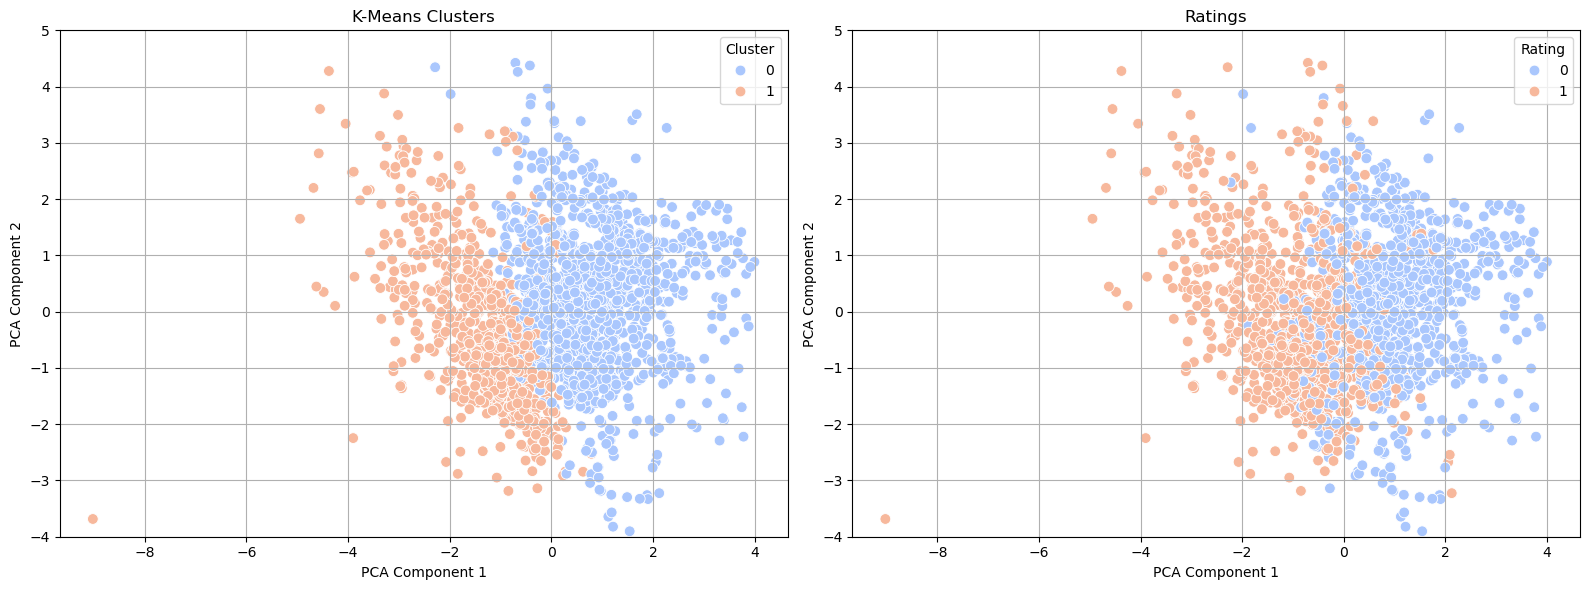

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

#Reduce to 2D PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

#check pca components
print(pca.components_)
print(list(features)) #this was defined in the Clusters section

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: GMM Clusters ---
sns.scatterplot(
    data=df, x='pca1', y='pca2', hue='cluster',
    palette='coolwarm', s=60, ax=axes[0]
)
axes[0].set_title("K-Means Clusters")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_ylim([-4, 5])  # Adjust y-axis here
axes[0].legend(title='Cluster')
axes[0].grid(True)

# --- Plot 2: S&P Ratings ---
sns.scatterplot(
    data=df, x='pca1', y='pca2', hue='rating_binary',
    palette='coolwarm', s=60, ax=axes[1]
)
axes[1].set_title("Ratings")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")
axes[1].set_ylim([-4, 5])
axes[1].legend(title='Rating')
axes[1].grid(True)

# Final layout
plt.tight_layout()

# Export to file
plt.savefig("pca_clusters_vs_ratings.png", dpi=300, bbox_inches='tight') 

plt.show()


In [19]:
def check_pre_default_probs(
    df, logit_model, X_train_features, defaults_dict,
    palette='tab10', style='seaborn-v0_8-darkgrid'
):
    """
    For each country and default year, plot predicted default probabilities 
    from the cluster model for years before the default, using modern plot styles.

    Parameters:
    - df: DataFrame with index 'ctry_year', and 'cluster' column
    - logit_model: trained logistic regression model on cluster dummies
    - X_train_features: columns used during model training
    - defaults_dict: dict of {country_code: default_year}
    - palette: matplotlib/seaborn color palette (default 'tab10')
    - style: matplotlib style (default 'seaborn-v0_8-darkgrid')
    """

    # Apply style
    plt.style.use(style)
    sns.set_palette(palette)

    # Extract country and year from index if not already
    if 'country' not in df.columns or 'year' not in df.columns:
        df['country'] = df.index.str.split('_').str[0]
        df['year'] = df.index.str.split('_').str[1].astype(int)

    for country, default_year in defaults_dict.items():
        subset = df[(df['country'] == country) & (df['year'] < default_year)].copy()
        if subset.empty:
            print(f"No data for {country} before {default_year}")
            continue

        # Create cluster dummies and align with training columns
        X_subset = pd.get_dummies(subset['cluster'], prefix='cluster', drop_first=True)
        X_subset = X_subset.reindex(columns=X_train_features, fill_value=0)

        # Predict probabilities
        subset['pred_default_prob'] = logit_model.predict_proba(X_subset)[:, 1]

        # Print preview
        print(f"\n🔎 Predicted default probabilities for {country} prior to {default_year} default:")
        print(subset[['year', 'cluster', 'pred_default_prob']])

        # Plot
        fig, ax = plt.subplots(figsize=(9, 4.5))
        sns.lineplot(data=subset, x='year', y='pred_default_prob', marker='o', ax=ax, label='Predicted Prob')
        ax.axvline(default_year, color='red', linestyle='--', linewidth=1.5, label='Default Year')
        ax.set_title(f"{country}: Predicted Default Probability Before {default_year}", fontsize=13, weight='bold')
        ax.set_xlabel("Year", fontsize=11)
        ax.set_ylabel("Probability", fontsize=11)
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
        plt.tight_layout()
        plt.savefig("defaultprob.png", dpi=300, bbox_inches='tight') 
        plt.show()



🔎 Predicted default probabilities for GRC prior to 2015 default:
           year  cluster  pred_default_prob
ctry_year                                  
GRC_2005   2005        0           0.113763
GRC_2006   2006        0           0.113763
GRC_2007   2007        0           0.113763
GRC_2008   2008        0           0.113763
GRC_2009   2009        0           0.113763
GRC_2010   2010        0           0.113763
GRC_2011   2011        0           0.113763
GRC_2012   2012        0           0.113763
GRC_2013   2013        1           0.854459
GRC_2014   2014        1           0.854459


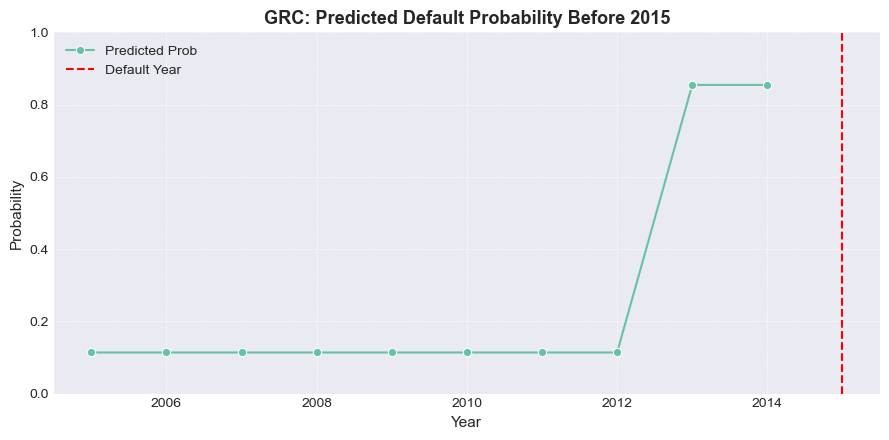

In [20]:
check_pre_default_probs(
    df=df,
    logit_model=logit_cluster,
    X_train_features=X_train_clust.columns,
    defaults_dict={'GRC': 2015},
    palette='Set2',
    style='seaborn-v0_8-darkgrid'
)
